# Define the problem

## Informal definition
Predict the price of shares based on historical data.

## Formal definition
- Task: predict the price of shares
- Exprerience: historical prices of shares from 1950 to 2012
- Performance: MAE, RMSE

## List assumptions
- time series analysis is the best practice for this problem
- observations are **time dependent**
- time series usually has seasonality, however it is not typical for stock price
- check stationarity;
- some dates are missing (weekends, bank holidays)
- usually close price is the target variable

## Problem solution

### Data cleaning
- convert Date column to datetime object;
- check presence of missing values and identify a strategy to work with them;
- sort dataset on Date column in ascending order;

### Programm design
- check stationarity;
- make time series stationary, if required;
- Use auto ARIMA and Prophet algos for final model

In [2]:
# Importing modules, reading data to pd.DataFrame and display first 5 rows
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


stocks = pd.read_csv('sphist.csv')
stocks.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


For the purpose of this project we will consider close price as the target. We will aslo drop column 'Adj Close' in order to avoid data leakage. 

## Data cleaning

In [3]:
# Drop column and display some info about dataset
stocks.drop('Adj Close', axis=1, inplace=True)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 6 columns):
Date      16590 non-null object
Open      16590 non-null float64
High      16590 non-null float64
Low       16590 non-null float64
Close     16590 non-null float64
Volume    16590 non-null float64
dtypes: float64(5), object(1)
memory usage: 777.7+ KB


It seems like there is no missing values in the dataset. Let's check this assumptions with histogram and display the minimun value in each column.

Date      1950-01-03
Open           16.66
High           16.66
Low            16.66
Close          16.66
Volume        680000
dtype: object


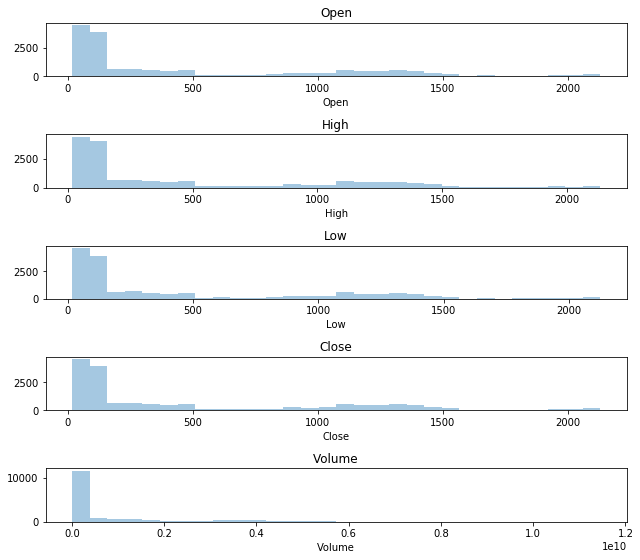

In [4]:
# Generate histograms
fig = plt.figure(figsize=(9, 9))
for i, col in enumerate(stocks.columns[1:]):
    chart = fig.add_subplot(len(stocks.columns), 1, i+1)
    sns.distplot(stocks[col], bins=30, kde=False)
    plt.title(col)
plt.tight_layout()
# Display minimum value in each column
print(stocks.min())

The data presented here is a time series. In order to work properly with that we will convert date column to datetime object and sort dataset by this column. We will only preserve rows which contains data on whole year.

In [5]:
stocks['Date'] = pd.to_datetime(stocks['Date'], format='%Y-%m-%d')
stocks.sort_values(by='Date', inplace=True)
stocks.set_index('Date', inplace=True)
del stocks.index.name
stocks = stocks[stocks.index > datetime(1950, 12, 31)]
print(stocks.head())
print(stocks.tail())

                 Open       High        Low      Close     Volume
1951-01-02  20.770000  20.770000  20.770000  20.770000  3030000.0
1951-01-03  20.690001  20.690001  20.690001  20.690001  3370000.0
1951-01-04  20.870001  20.870001  20.870001  20.870001  3390000.0
1951-01-05  20.870001  20.870001  20.870001  20.870001  3390000.0
1951-01-08  21.000000  21.000000  21.000000  21.000000  2780000.0
                   Open         High          Low        Close        Volume
2015-12-01  2082.929932  2103.370117  2082.929932  2102.629883  3.712120e+09
2015-12-02  2101.709961  2104.270020  2077.110107  2079.510010  3.950640e+09
2015-12-03  2080.709961  2085.000000  2042.349976  2049.620117  4.306490e+09
2015-12-04  2051.239990  2093.840088  2051.239990  2091.689941  4.214910e+09
2015-12-07  2090.419922  2090.419922  2066.780029  2077.070068  4.043820e+09


## Getting familiar with the data

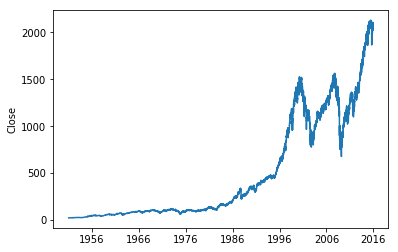

In [6]:
sns.lineplot(stocks.index, stocks['Close'])

We can observe increasing trend. At this point it is hard to say if there are season variation. However, the basic assumption is that the share price doesn't depend on season. 

As we are working with the time series data we should check for stationarity. To do this we will:
- generate some charts with rolling statisctis;
- use Dickey-Fuller test; 

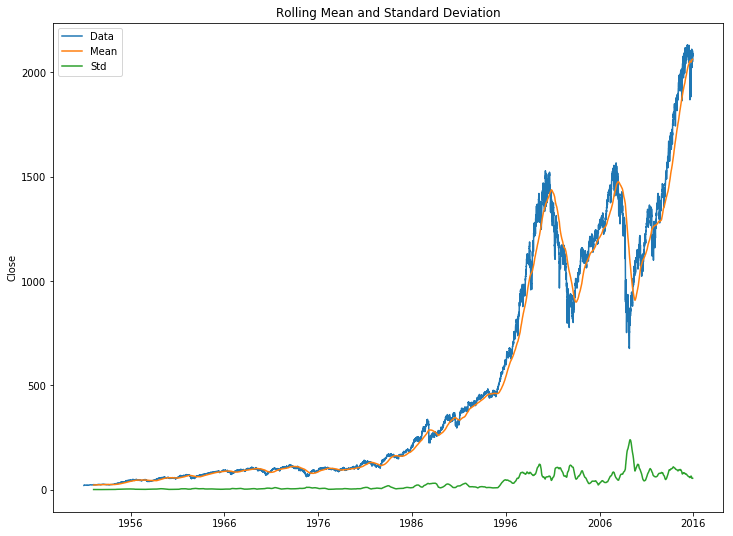

Dickey-Fuller test results
Test Statistic 1.817468365913361
p-value        0.998383040751901
Number of lags 43
Number of Obs  16297


In [7]:
# Define function to check stationarity
def check_stat(ts):
    # Calculate the rolling statistics
    rolmean = ts.rolling(window=260).mean() # 260 is mean number of working days per year
    rolstd = ts.rolling(window=260).std()
    # Plot the graphs
    plt.figure(figsize=(12, 9))
    data = sns.lineplot(ts.index, ts, label='Data')
    mean = sns.lineplot(ts.index, rolmean, label = 'Mean')
    std = sns.lineplot(ts.index, rolstd, label = 'Std')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.show()
    
    print('Dickey-Fuller test results')
    df_test = adfuller(ts)
    layout = ['Test Statistic', 'p-value       ', 'Number of lags', 'Number of Obs ']
    for i, j in enumerate(df_test[:4]):
        print(layout[i], j)
    
check_stat(stocks['Close'])

We can see that the mean is increasing over time and the standard deviation is not constant from 1986. The p-value is also reveals that this time series is not stationary. Let's try to remove the trend by differencing. 

## Prepare data for analysis

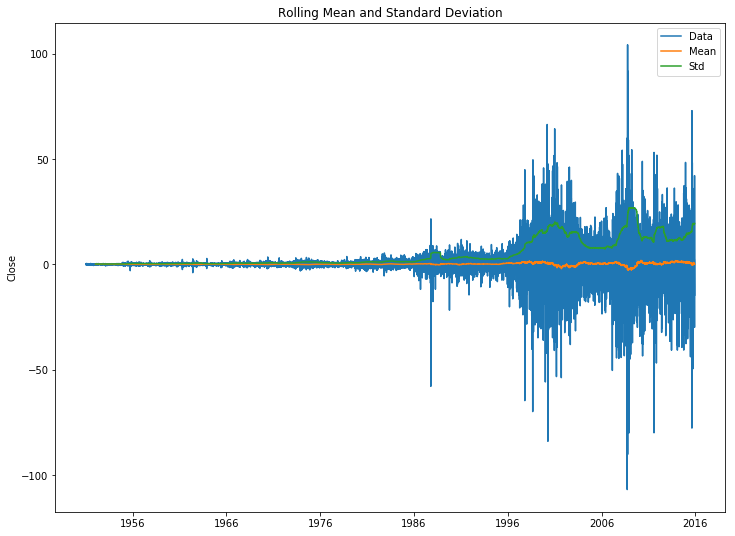

Dickey-Fuller test results
Test Statistic -20.5458382867645
p-value        0.0
Number of lags 42
Number of Obs  16298


In [8]:
diff = stocks['Close'].rolling(window=2).apply(lambda x: x[1] - x[0], raw=False).fillna(0)
check_stat(diff)

We can observe that the p-value has become zero, so this method of detrending works well for this series. The series might be considered now as stationary. Let's define a function to transform our data.

In [9]:
def transform(data):
    data = data.copy()
    # Find the difference for each column
    for col in data.columns:
        new_col = data[col].rolling(window=2).apply(lambda x: x[1] - x[0], raw=False)
        data[col] = new_col
        data.dropna(how='all', inplace=True)
    return data

ts_stocks = transform(stocks)

Now we have our data stationary and a bit transformed. We can move to data model building.

## Model selection

As we are working with time series we will use the following models:
- Auto ARIMA;
- Prophet; 

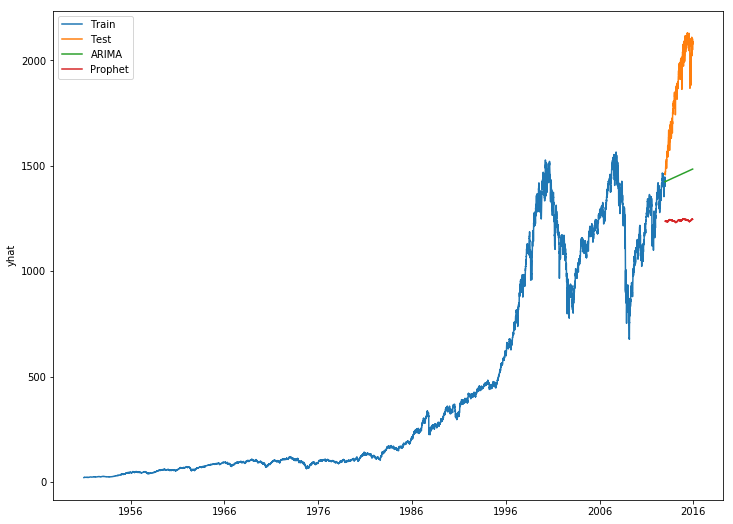

ARIMA RMSE: 455.9133669271475
Prophet RMSE: 662.7280463653391


In [39]:
def arima_predictions(data):
    # Create train and test datasets
    train = data[data.index < datetime(2013, 1, 1)]
    test = data[data.index >= datetime(2013, 1, 1)]
    
    # Fit ARIMA model
    model = auto_arima(train, error_action='ignore', suppress_warnings=True)
    model.fit(train)
    
    # Make and return predictions 
    return model.predict(n_periods=len(test)), train, test

def prophet_predictions(train, test):
    # Create train and test datasets
    train = train.reset_index().rename(columns={'index': 'ds', 'Close': 'y'})
    test = test.reset_index().rename(columns={'index': 'ds', 'Close': 'y'})

    # Fit Prophet model
    model = Prophet(daily_seasonality=True)
    model.fit(train)
    
    # Make predictions
    predictions = model.make_future_dataframe(periods=len(test))
    return model.predict(predictions)['yhat'][15602:]
    

def implementation(ts):
    # Create train and test datasets
    data = ts['Close']
    
    # Make ARIMA predictions
    predictions_arima, train, test = arima_predictions(data)
    # Make Prophet predictions
    predictions_prophet = prophet_predictions(train, test)
    
    # Plot the data
    plt.figure(figsize=(12, 9))
    sns.lineplot(train.index, train.values, label='Train')
    sns.lineplot(test.index, test.values, label='Test')
    sns.lineplot(test.index, predictions_arima, label='ARIMA')
    sns.lineplot(test.index, predictions_prophet, label='Prophet')
    plt.show()
    
    rmse_arima = np.sqrt(mean_squared_error(test, predictions_arima))
    rmse_prophet = np.sqrt(mean_squared_error(test, predictions_prophet))
    
    print('ARIMA RMSE: {}'.format(rmse_arima))
    print('Prophet RMSE: {}'.format(rmse_prophet))
    
implementation(stocks)